In [1]:
from Binaries import *

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
Events = EventGenerator("19_19.5", split = 1, apply_downsampling = True, seed = 42)

example_traces = Events.__getitem__(0)

[INFO] -- LOADING NURIA: randoms0117.csv                                                            


In [3]:
prepared_traces = []

for i in range(1,5):

    trace = np.array(1/3 * ( example_traces[i].pmt_1 + example_traces[i].pmt_2 + example_traces[i].pmt_3 ))
    trace = trace / max(trace)

    trace = np.insert(trace, 0, example_traces[i].signal_end)
    trace = np.insert(trace, 0, example_traces[i].signal_start)
    prepared_traces.append(trace)

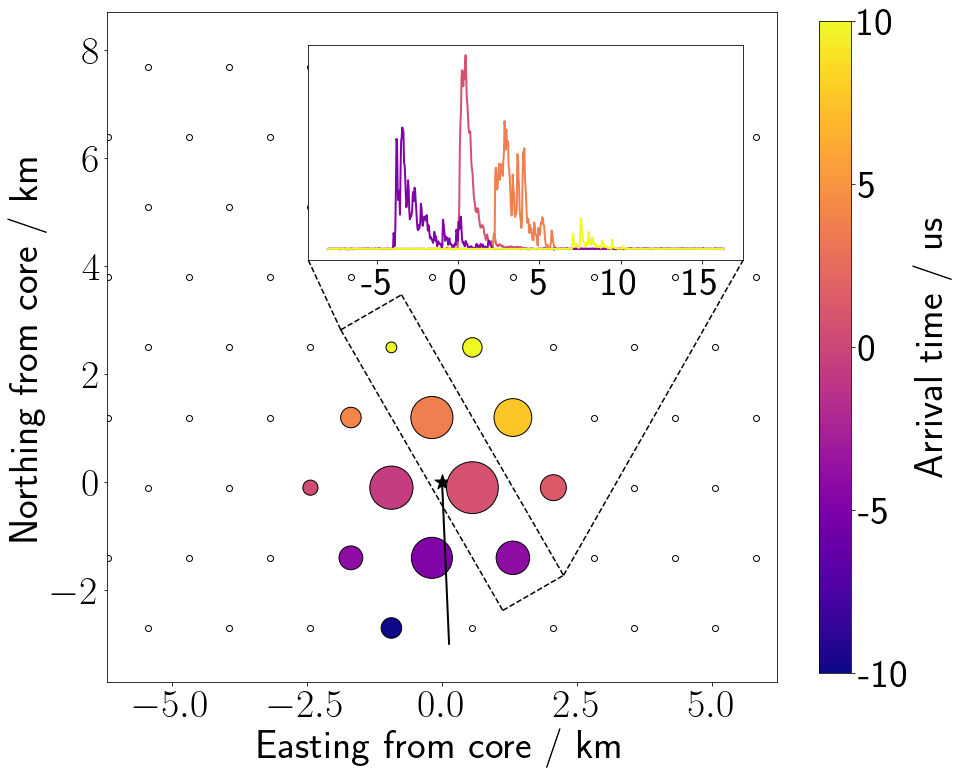

In [6]:
def hexit_60(n_max):
    pairs = []
    if n_max >= 0:
        pairs.append(np.zeros(2, dtype=int)[:, None])
    if n_max >= 1:
        seq = [1, 0, -1]
        p0  = np.hstack((seq, seq[::-1]))
        N   = len(p0)
        p1  = np.hstack((p0[N-2:], p0[:N-2]))
        pairs.append(np.stack((p0, p1), axis=0))
    for n in range(2, n_max+1):
        seq = np.arange(n, -n-1, -1, dtype=int)
        p0  = np.hstack((seq, (n-1)*[-n], seq[::-1], (n-1)*[n]))
        N   = len(p0)
        p1  = np.hstack((p0[N-2*n:], p0[:N-2*n]))
        pairs.append(np.stack((p0, p1), axis=0))
    if len(pairs) > 0:
        pairs = np.hstack(pairs)
    else:
        pairs = None
    return pairs

def get_points(a, n_max):
    vecs = a * np.array([[1.0, 0.0], [0.5, 0.5*np.sqrt(3)]])
    pairs = hexit_60(n_max = n_max)
    if isinstance(pairs, np.ndarray):
        points = (pairs[:, None]*vecs[..., None]).sum(axis=0)
    else:
        points = None
    return points



fig = plt.figure()
ax1 = plt.gca()

colormap = plt.get_cmap('plasma')
x, y = np.meshgrid(np.linspace(-6, 6, 5), np.linspace(300, 850, 20))
z1 = np.cos(x) + np.sin(y / 100)
vmin, vmax = z1.min(), z1.max()
placeholder = ax1.contourf(x, y, z1, cmap=colormap, vmin=vmin, vmax=vmax, levels = 100)

points = get_points(a=1.5, n_max=8)
x, y = points
x += 0.562
y -= 0.109

# plot array and core
ax1.scatter(x, y, facecolor = "white", edgecolor = "k")
ax1.scatter(0, 0, color = "k", marker = "*", s = 250)
ax1.plot([0, 0.13], [0, -3], c = "k", lw = 2)

# plot signals
radius = [0.48, 0.24, 0.35, 0.39, 0.40, 0.38, 0.31, 0.25, 0.19, 0.18, 0.18, 0.1, 0.19, 0.14, 0.22, 0.19]
times = [2,2,3,3,2,1,1,4,4,3,2,1,0]
actual_times = []
actual_stations = []

for i, p in enumerate([0,1,2,3,4,5,6,10,11,12,13,14,15]):
    time = times[i]/4 + np.random.normal(0, scale = 0.07)
    ax1.add_patch(plt.Circle((x[p],y[p]), radius[p], fc = cmap.plasma(time), ec = "k"))
    actual_stations.append([x[p], y[p]])
    actual_times.append(time)

actual_stations = np.array(actual_stations)
cax = plt.colorbar(placeholder, ax = ax1, label = r"Arrival time / us", ticks = np.linspace(-2,2,5), shrink = 0.8)
cax.set_ticklabels([int(tick) for tick in np.linspace(-10, 10, 5)])
ax1.set_xlabel("Easting from core / km")
ax1.set_ylabel("Northing from core / km")

x1 = x[26] + 0.25 * np.abs(x[24] - x[26])
x2 = x[24] - 0.25 * np.abs(x[24] - x[26])
y1 = y[26] + 0.25 * np.abs(y[24] - y[26])
y2 = y[24] - 0.25 * np.abs(y[24] - y[26])
x3 = x[16] + 0.25 * np.abs(x[18] - x[16])
x4 = x[18] - 0.25 * np.abs(x[18] - x[16])
y3 = y[16] + 0.25 * np.abs(y[18] - y[16])
y4 = y[18] - 0.25 * np.abs(y[18] - y[16])

plt.plot([x1, x2], [y1, y2], c = "k", ls = "--")
plt.plot([x3, x4], [y3, y4], c = "k", ls = "--")
plt.plot([x2, x4], [y2, y4], c = "k", ls = "--")
plt.plot([x1, x3], [y1, y3], c = "k", ls = "--")

xlim_low, xlim_high = -6.2, 6.2
ylim_low, ylim_high = -3.7, 8.7

traces = ax1.inset_axes([0.3,0.63,0.65,0.32])
traces.set_yticks([])
ax1.plot([x1, xlim_low + 0.3 * 12.4], [y1, ylim_high - 0.37 * 12.4], ls = "--", c = "k")
ax1.plot([x4, xlim_high - 0.05 * 12.4], [y4, ylim_low + 0.63 * 12.4], ls = "--", c = "k")

ax1.set_xlim(xlim_low, xlim_high)
ax1.set_ylim(ylim_low, ylim_high)
ax1.set_aspect('equal')

signal_bin = 10

for i, p in enumerate([0,3,5,8]):

    if p == 11: x = 7
    else : x = p

    time = actual_times[x]
    size = radius[x]

    trace = prepared_traces[i]
    start, end = int(trace[0]), int(trace[1])
    trace = trace[2:]

    signal = trace[start : end]
    background = np.concatenate([trace[:start], trace[end:]])

    this_time_bin = np.max(int( signal_bin + 400 * time ), 0)

    trace = np.insert(background, this_time_bin, signal)

    traces.plot(range(len(trace)), trace * size**2, color = cmap.plasma(time), lw = 2)

    if p == 0: save = this_time_bin

increment = 140
traces.set_xticks([save,save - increment, save + increment, save + 2 * increment, save + 3 * increment],[r"0", r"-5", r"5", r"10", r"15"])

plt.rcParams["figure.figsize"] = [15, 15]
plt.show()

